<a href="https://colab.research.google.com/github/NOBODIDI/APS360_GeoGuessr_NN/blob/main/baseline/KNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KKN Image Classification Model

This code is taken from and adapted for our purposes:
https://www.youtube.com/watch?v=Rj9gSsB7kdw&t=486s 

From our data set of 7983 images spanning 80 classes, we will use the same 70% Training data set as our Primary Model and combine our primary model's Test and Validation data sets to form a 30% Test set for our KNN, as this baseline model requires no training or hyperparameter tuning. 


This KNN is a 70-Nearest Neighbor Model, which computes the average euclidean distance between a given flattened RGB test image and the ~70 flattened training images in each of the 80 geo-cells. The model returns the geo-cell/class that the images is mostlikely to belong to, ie the class with the lowest average euclidean distance.

# Import Necessary Libraries 

In [ ]:
# import necessary libraries
import scipy.io as sio
import math
from statistics import mean

# extras from our primary model
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil
import time
import copy

# Mount Google Drive to find 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import  and Process Images from Data set
In this section of code we will be flatten the images imported/downloaded in the previous section, then split these images into the same 0.7/0.3 'Training' to Test split discussed in the mode of this Colab Notebook.

In this section we will also resize/crop the images to the same dimensions as our primary model if the image dataset is not already resized.



In [ ]:

# Initialise dictionaries for 70% training and 30% test image data sets
train_dict={}
test_dict={}

root_path = '/content/drive/MyDrive/APS360 - Deep Learning Project  (1)/Colab Notebooks/train_val_test_split'

for folder in ['train','val','test']:
  # Build a in 'training' dictionary for each training image in each geocell
  if folder == 'train':

    folder_path = os.path.join(root_path,folder)
    counter=0
    # looping through Geocell IDs
    
    for ID in os.listdir(folder_path):
      # Initialise an empty list for the key value of each geocell ID
      ID_int = int(ID)
      train_dict[ID_int] = []
      ID_path = os.path.join(folder_path,ID)

      # Counter to gauge progress:
      
      # Loop through each image in that folder and update dictionary list
      for filename in os.listdir(ID_path):
        if filename.endswith(".png"):
          image_path = os.path.join(ID_path,filename)
          image = plt.imread(image_path,0)
          train_dict[ID_int].append(image.flatten())
          counter+=1
      print("Folder:",folder,"|  Current ID:",ID,"|  Counter:",counter,"/5588")
    
    # Reset counter for progress report folders val and test
    counter=0
  
  
  # no the same process but for the 30% KNN test data set
  else:

    folder_path = os.path.join(root_path,folder)

    # looping through Geocell IDs
    for ID in os.listdir(folder_path):
      # Initialise an empty list for the key value of each geocell ID
      ID_int = int(ID)
      test_dict[ID_int] = []
      ID_path = os.path.join(folder_path,ID)

      # Loop through each image in that folder and update dictionary list
      for filename in os.listdir(ID_path):
        if filename.endswith(".png"):
          image_path = os.path.join(ID_path,filename)
          image = plt.imread(image_path,0)
          test_dict[ID_int].append(image.flatten())
          counter+=1
      print("Folder:",folder,"|  Current ID:",ID,"|  Counter:",counter,"/2395") 


Folder: train |  Current ID: 99 |  Counter: 77 /5588
Folder: train |  Current ID: 41 |  Counter: 147 /5588
Folder: train |  Current ID: 135 |  Counter: 216 /5588
Folder: train |  Current ID: 63 |  Counter: 292 /5588
Folder: train |  Current ID: 62 |  Counter: 363 /5588
Folder: train |  Current ID: 23 |  Counter: 432 /5588
Folder: train |  Current ID: 131 |  Counter: 502 /5588
Folder: train |  Current ID: 117 |  Counter: 573 /5588
Folder: train |  Current ID: 93 |  Counter: 634 /5588
Folder: train |  Current ID: 114 |  Counter: 696 /5588
Folder: train |  Current ID: 81 |  Counter: 759 /5588
Folder: train |  Current ID: 71 |  Counter: 829 /5588
Folder: train |  Current ID: 57 |  Counter: 902 /5588
Folder: train |  Current ID: 120 |  Counter: 968 /5588
Folder: train |  Current ID: 173 |  Counter: 1037 /5588
Folder: train |  Current ID: 97 |  Counter: 1104 /5588
Folder: train |  Current ID: 86 |  Counter: 1177 /5588
Folder: train |  Current ID: 103 |  Counter: 1247 /5588
Folder: train |  C

# Running 70-NN Model    
Compute the euclidean distances between test and all the training images from each geo-cell class.

Joshua's Notes: 
I see two possibilities to make the correct classification:      

1) The minimum euclidean distance in each geocell 

2) The average euclidean distance of each geocell

Because of the large geographical area each geocell respresents there is a possibility the wide variabilities in terrain and features will lead to roughly equivalent averages accross the classes. Therefore, for the sake of experimentation I will store both of these values and see what results they yield.    

In [ ]:

################################################################################ 
# DON'T RUN it takes 30+ mins to Compute the 80- scores for all 2395 images
################################################################################
 
# Initialise a results dictionary
# keys: geo-cell ID of test images (correct class)
# values: a list of tuples storing the 80 geo-cell-euclidean distance pair for each image
#         [[(Geo-cell ID, Avg Euclidean distance, Min Euclidean distance),(),..],[(),(),..],..]

results_dict = {}
class_counter=0 
for test_ID in test_dict.keys():
  # Initialise empty values list
  results_dict[test_ID]=[]
  class_counter+=1
  
  for test_image in test_dict[test_ID]:
    # Initialise empty list to store the 80 distances from each class
    test_image_results=[]
    
    for train_ID in train_dict.keys():
    #for train_ID in range(len(train_dict.keys())):
      # Initialise empty Euclidean distance list 
      euclid_dist=[]

      for train_image in train_dict[train_ID]:
        # Compute Euclidean distance between images
        euclid_dist.append(np.linalg.norm(test_image-train_image))
      
      # Compute Average Euclidean distance of geo-cell
      avg_euclid_dist = mean(euclid_dist)
      
      # Find Minimum Euclidean distance in geo-cell
      min_euclid_dist = min(euclid_dist)
      
      # Format Tuple and to results dictionary
      test_image_results.append((train_ID, avg_euclid_dist, min_euclid_dist))
    results_dict[test_ID].append(test_image_results)
  #print(results_dict) 
  # To track runtime progress 
  print("Test ID:",test_ID,"|   Percent Complete:", class_counter*100/80,"%")     
  

Test ID: 22 |   Percent Complete: 1.25 %
Test ID: 117 |   Percent Complete: 2.5 %
Test ID: 95 |   Percent Complete: 3.75 %
Test ID: 81 |   Percent Complete: 5.0 %
Test ID: 87 |   Percent Complete: 6.25 %
Test ID: 44 |   Percent Complete: 7.5 %
Test ID: 115 |   Percent Complete: 8.75 %
Test ID: 205 |   Percent Complete: 10.0 %
Test ID: 118 |   Percent Complete: 11.25 %
Test ID: 152 |   Percent Complete: 12.5 %
Test ID: 69 |   Percent Complete: 13.75 %
Test ID: 113 |   Percent Complete: 15.0 %
Test ID: 102 |   Percent Complete: 16.25 %
Test ID: 150 |   Percent Complete: 17.5 %
Test ID: 85 |   Percent Complete: 18.75 %
Test ID: 187 |   Percent Complete: 20.0 %
Test ID: 75 |   Percent Complete: 21.25 %
Test ID: 206 |   Percent Complete: 22.5 %
Test ID: 63 |   Percent Complete: 23.75 %
Test ID: 78 |   Percent Complete: 25.0 %
Test ID: 132 |   Percent Complete: 26.25 %
Test ID: 83 |   Percent Complete: 27.5 %
Test ID: 119 |   Percent Complete: 28.75 %
Test ID: 79 |   Percent Complete: 30.0 %

In [ ]:
  
def get_KNN_accuracy(results_dict):       
  counter_min = counter_avg = total_counter = 0        
  count_zero = 0 
  for class_ID in results_dict.keys():
    total_counter += len(results_dict[class_ID]) 
    #print(len(results_dict[class_ID]))   
      
    for i in range(0,len(results_dict[class_ID])):
      results_dict[class_ID][i].sort(key=lambda x: x[1])
      #print(class_ID, ": ", results_dict[class_ID][i])
      #print(class_ID, "vs", results_dict[class_ID][i][0][0]) 
      if (results_dict[class_ID][i][0][0] == class_ID):  
        counter_avg += 1
      #print("counter_avg: ", counter_avg)
      if(results_dict[class_ID][i][0][1] == float(0)): 
        count_zero += 1
      
      results_dict[class_ID][i].sort(key=lambda x: x[2])
      #print(class_ID, ": ", results_dict[class_ID][i])
      #print(class_ID, 'vs', results_dict[class_ID][i][0][0])      
      if (results_dict[class_ID][i][0][0] == class_ID): 
        counter_min += 1
      #print("counter_min: ", counter_min)
      
    print("\n") 
  avg_final_acc = counter_avg/total_counter * 100 
  min_final_acc = counter_min/total_counter * 100
  
  print("Avg final acc:", avg_final_acc)  
  print("Min final acc:", min_final_acc) 

  return 

 
get_KNN_accuracy(results_dict)

































































































































































Avg final acc: 1.2515644555694618
Min final acc: 2.127659574468085


In [ ]:
#for ID in results_dict.keys(): 
#  print(ID)
# 22 is one of the test_ID, but it still gives an error when I try to print statement below??? 
#print(results_dict['22'][0][1])
print(results_dict[61][0][0][0])
#print(len(results_dict[22]))
#for train_ID in train_dict.keys():
#  print(train_ID)
#  print(type(train_ID)) 

99


#Confusion Matrix

80


































































































































































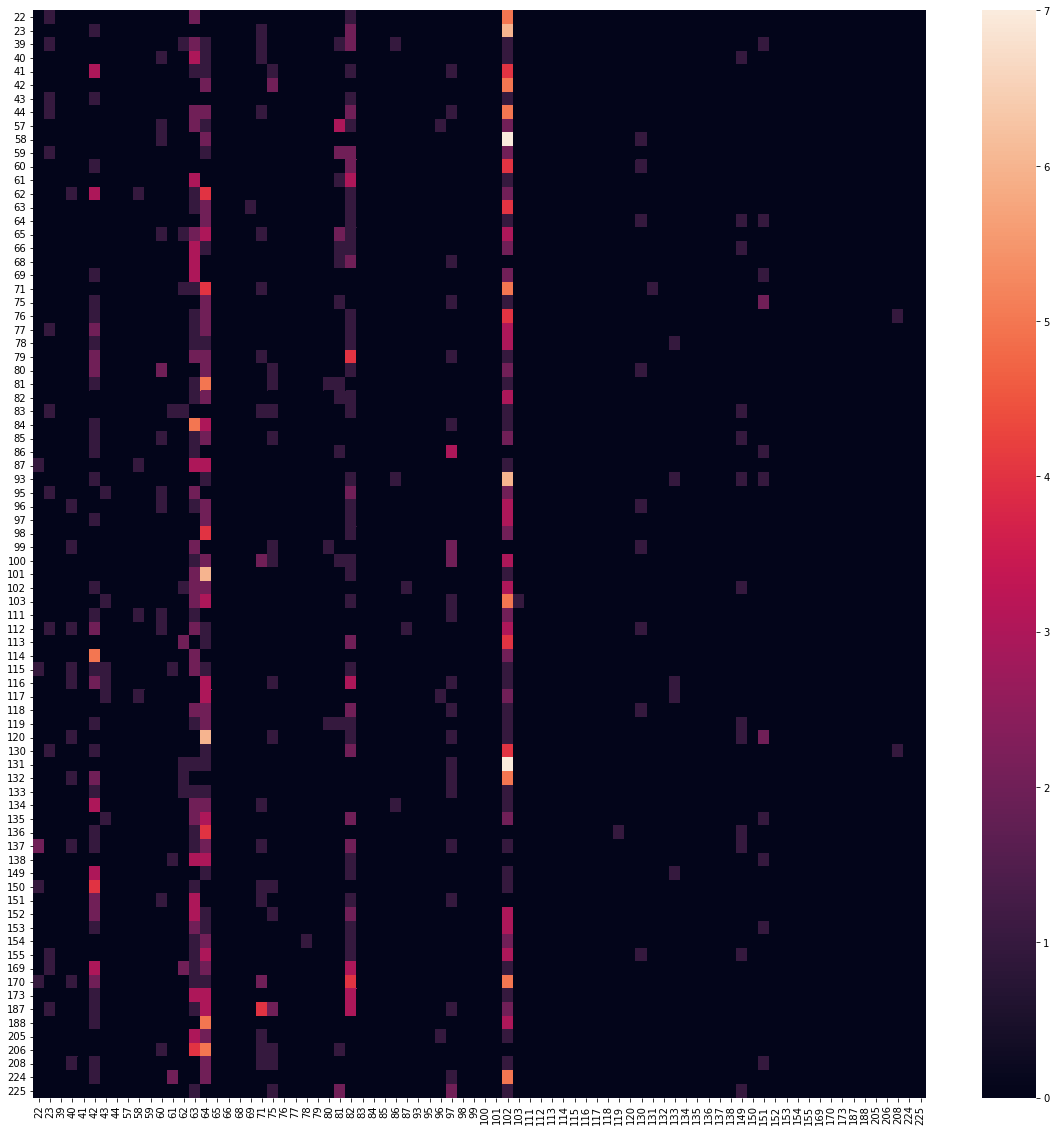

In [ ]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
'''
should create 2 confusion matrices, one for the avg and one for the min

'''
@torch.no_grad()
def get_KNN_confusion(results_dict):  
  counter_min = counter_avg = total_counter = 0    
  count_zero = 0 

  # confusion matrix setup: 
  num_classes = 80
  # iterable list of int class names
  classes = [] * num_classes
  # str list to display
  class_names = [] * num_classes

  count1 = 1
  for ID in os.listdir(folder_path):
    ID_int = int(ID)
    if count1 < 81:
      classes.append(ID_int)
      count1 += 1

  count2 = 0
  classes.sort()
  for ID in classes:
    ID_str = str(ID)
    if count2 < 81:
      class_names.append(ID_str)
      count2 += 1
  print(len(classes))
  '''
  Confusion Matrix 1
  '''
  # Create empty confusion matrix tensor (cmt)
  cmt1 = torch.zeros(num_classes,num_classes, dtype = torch.int64)
  '''
  Confusion Matrix 2

  # Create empty confusion matrix tensor (cmt)
  cmt2 = torch.zeros(num_classes,num_classes, dtype = torch.int64)
    '''

  for class_ID in results_dict.keys():
    total_counter += len(results_dict[class_ID])
    #print(len(results_dict[class_ID]))
    
    for i in range(0,len(results_dict[class_ID])):
      results_dict[class_ID][i].sort(key=lambda x: x[1])
      #print(class_ID, ": ", results_dict[class_ID][i])
      #print(class_ID, "vs", results_dict[class_ID][i][0][0])
      if (results_dict[class_ID][i][0][0] == class_ID): 
        counter_avg += 1
      #print("counter_avg: ", counter_avg)
      if(results_dict[class_ID][i][0][1] == float(0)): 
        count_zero += 1
      # add code for confusion avg
      # Update the score in confusion matrix, do this for every image
      #truth_label_idex1 = classes.index(classes[int(class_ID)])
      #prediction_idex1 = classes.index(classes[int(results_dict[class_ID][i][0][0])])
      truth_label_idex1 = classes.index(int(class_ID))
      prediction_idex1 = classes.index(int(results_dict[class_ID][i][0][0]))
      cmt1[truth_label_idex1][prediction_idex1] += 1

      results_dict[class_ID][i].sort(key=lambda x: x[2])
      #print(class_ID, ": ", results_dict[class_ID][i])
      #print(class_ID, 'vs', results_dict[class_ID][i][0][0])      
      if (results_dict[class_ID][i][0][0] == class_ID): 
        counter_min += 1
      #print("counter_min: ", counter_min)
      #add code for confusion min 
      # Update the score in confusion matrix, do this for every image
      '''
      truth_label_idex2 = classes.index(classes[int(class_ID)])
      print(classes.index(classes[int(results_dict[class_ID][i][0][0])]))
      prediction_idex2 = classes.index(classes[int(results_dict[class_ID][i][0][0])])
      cmt2[truth_label_idex2][prediction_idex2] += 1
      '''
      
    print("\n") 
  avg_final_acc = counter_avg/total_counter * 100
  min_final_acc = counter_min/total_counter * 100
  
  #print("Avg final acc:", avg_final_acc)  
  #print("Min final acc:", min_final_acc)

  '''
  Confusion Matrix 1
  '''
  #print confusion table 1 and 2
  plt.figure(figsize=(num_classes/4,num_classes/4))
  x_axis_labels = class_names
  y_axis_labels = class_names 
  f = sns.heatmap(cmt1, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  '''
  Confusion Matrix 2

  #print confusion table 1 and 2
  plt.figure(figsize=(num_classes/4,num_classes/4)) # is this line necessary
  f = sns.heatmap(cmt2, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  '''
  return


get_KNN_confusion(results_dict)
